### Libraries

In [ ]:
import wfdb
import numpy as np
import pywt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, LSTM, Dense, Input, Add, Multiply
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, LeakyReLU, Input, Add


### Signal Visualization

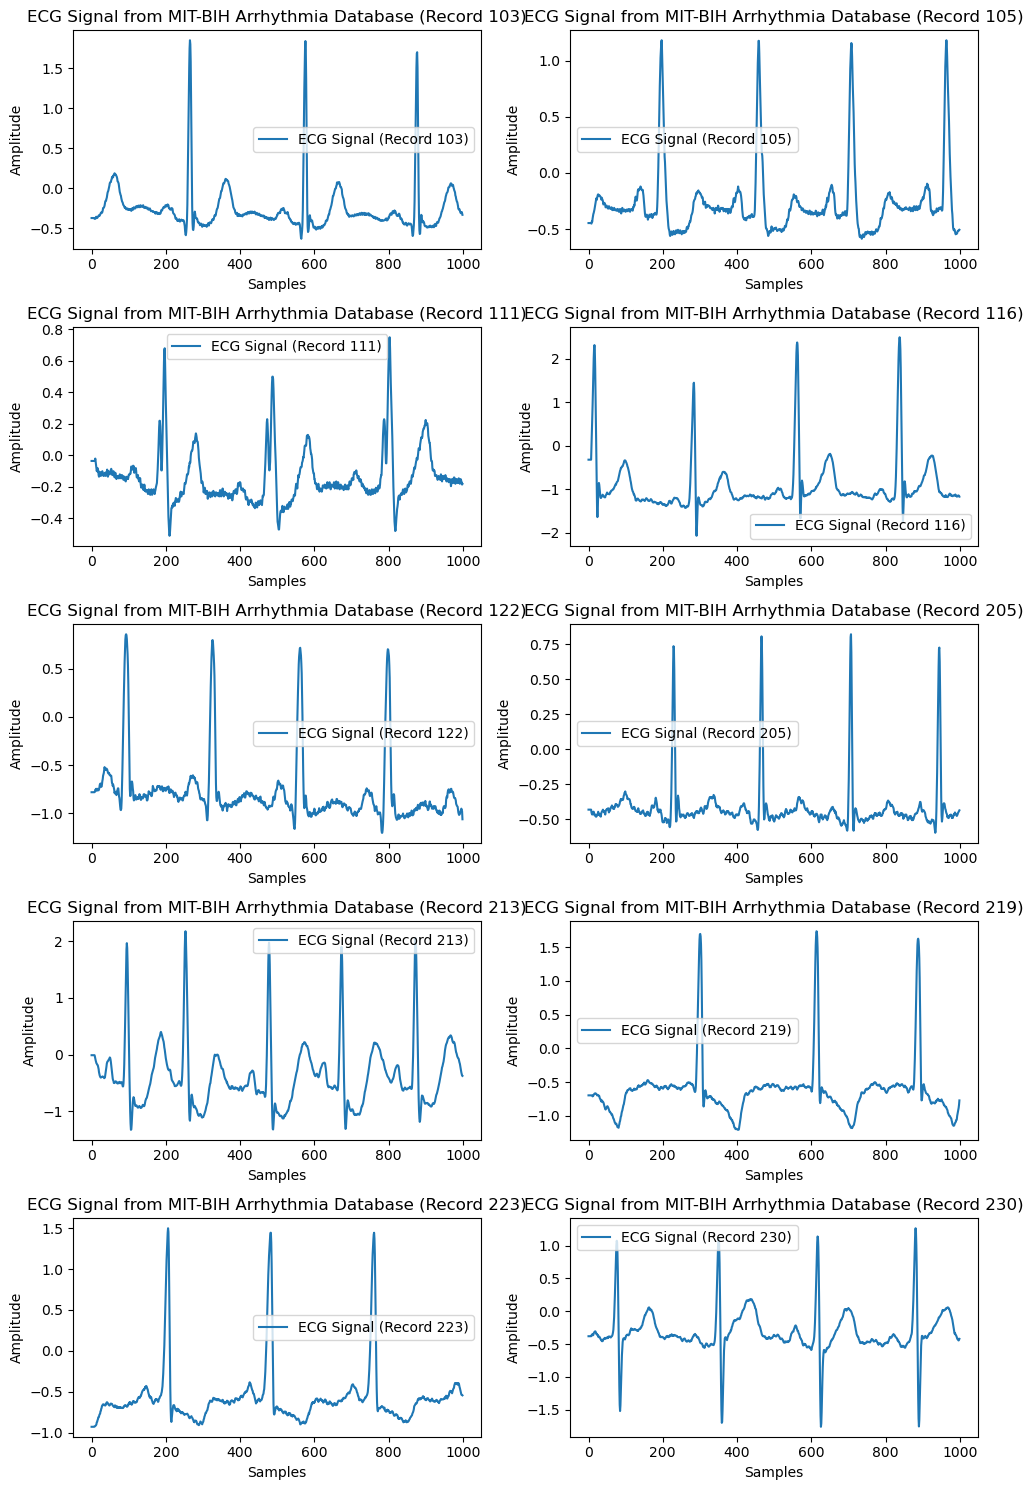

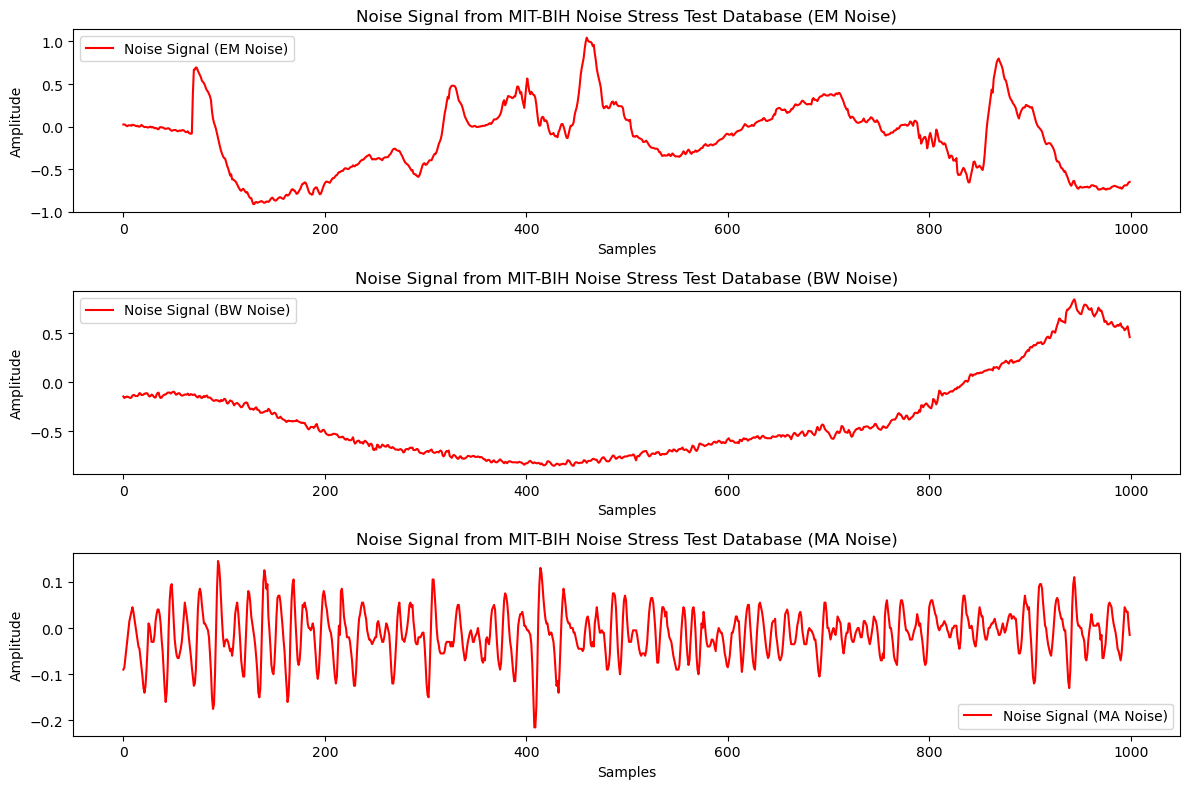

In [5]:
# Define the base path to the arrhythmia and noise records
base_path_arrhythmia = 'C:\\Users\\malik\\Desktop\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0\\'
base_path_noise = 'C:\\Users\\malik\\Desktop\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\'

# List of arrhythmia record numbers
arrhythmia_records = ['103', '105', '111', '116', '122', '205', '213', '219', '223', '230']

# List of noise record types
noise_records = ['em', 'bw', 'ma']

# Plot the raw ECG signals
plt.figure(figsize=(10, 15))
for i, record in enumerate(arrhythmia_records):
    record_path = base_path_arrhythmia + record
    ecg_record = wfdb.rdrecord(record_path)
    ecg_signal = ecg_record.p_signal[:, 0]  # Using the first lead

    plt.subplot(5, 2, i + 1)
    plt.plot(ecg_signal[:1000], label=f'ECG Signal (Record {record})')
    plt.title(f'ECG Signal from MIT-BIH Arrhythmia Database (Record {record})')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()

plt.tight_layout()
plt.show()

# Plot the noise signals
plt.figure(figsize=(12, 8))
for i, noise in enumerate(noise_records):
    noise_path = base_path_noise + noise
    noise_record = wfdb.rdrecord(noise_path)
    noise_signal = noise_record.p_signal[:, 0]

    plt.subplot(3, 1, i + 1)
    plt.plot(noise_signal[:1000], label=f'Noise Signal ({noise.upper()} Noise)', color='red')
    plt.title(f'Noise Signal from MIT-BIH Noise Stress Test Database ({noise.upper()} Noise)')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()

plt.tight_layout()
plt.show()


### Modle 1: CAE-GAN with and without z

In [ ]:

# Define the ECGDataset class
class ECGDataset(Dataset):
    def __init__(self, raw_signals, noisy_signals):
        self.raw_signals = raw_signals
        self.noisy_signals = noisy_signals

    def __len__(self):
        return len(self.raw_signals)

    def __getitem__(self, idx):
        raw_signal = self.raw_signals[idx]
        noisy_signal = self.noisy_signals[idx]
        return torch.tensor(raw_signal, dtype=torch.float32), torch.tensor(noisy_signal, dtype=torch.float32)

# Define the add_noise function
def add_noise(signal, noise, snr):
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    factor = 10 * ((signal_power / noise_power) / (10 ** (snr / 10)))
    noisy_signal = 100 * (signal + noise * np.sqrt(factor))
    return noisy_signal

# Define the load_mit_bih_data function
def load_mit_bih_data(records, noise_type, snr_levels, target_length=650000):
    raw_signals = []
    noisy_signals_dict = {snr: [] for snr in snr_levels}
    
    for record in records:
        raw_record = wfdb.rdrecord(f'M:\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{record}')
        raw_signal = raw_record.p_signal[:, 0]  # Use the first channel for simplicity
        
        # Load noise and add it to the raw signal
        noise_record = wfdb.rdrecord(f'M:\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0/{noise_type}')
        noise_signal = noise_record.p_signal[:, 0]
        
        # Ensure the signals are of the same length
        min_length = min(len(raw_signal), len(noise_signal), target_length)
        raw_signal = raw_signal[:min_length]
        noise_signal = noise_signal[:min_length]
        
        # Pad signals to target length
        if min_length < target_length:
            raw_signal = np.pad(raw_signal, (0, target_length - min_length), 'constant')
            noise_signal = np.pad(noise_signal, (0, target_length - min_length), 'constant')
        
        raw_signals.append(raw_signal)
        
        for snr in snr_levels:
            noisy_signal = add_noise(raw_signal, noise_signal, snr)
            noisy_signals_dict[snr].append(noisy_signal)
    
    return np.array(raw_signals), {snr: np.array(noisy_signals_dict[snr]) for snr in snr_levels}

# Select records and noise types for the experiment
records = ['103', '105', '111', '116', '122', '205', '213', '219', '223', '230']
noise_types = ['bw', 'em', 'ma']
combined_noise_types = ['em+bw', 'ma+bw', 'ma+em', 'ma+em+bw']
snr_levels = [0, 1, 2, 3, 4, 5]
target_length = 649984

raw_signals, noisy_signals_dict = {}, {}
for noise_type in noise_types:
    raw_signals[noise_type], noisy_signals_dict[noise_type] = load_mit_bih_data(records, noise_type, snr_levels, target_length)

# For combined noise types, combine the corresponding noises
for combined_noise in combined_noise_types:
    components = combined_noise.split('+')
    combined_raw_signals, combined_noisy_signals = [], {snr: [] for snr in snr_levels}
    for i in range(len(records)):
        combined_signal = np.zeros(target_length)
        for component in components:
            raw_signal = raw_signals[component][i]
            combined_signal += raw_signal / len(components)  # Average the signals
        combined_raw_signals.append(combined_signal)
        for snr in snr_levels:
            combined_noise_signal = np.zeros(target_length)
            for component in components:
                noise_signal = noisy_signals_dict[component][snr][i]
                combined_noise_signal += noise_signal / len(components)  # Average the noises
            combined_noisy_signals[snr].append(combined_noise_signal)
    raw_signals[combined_noise] = np.array(combined_raw_signals)
    noisy_signals_dict[combined_noise] = {snr: np.array(combined_noisy_signals[snr]) for snr in snr_levels}

# Create datasets and dataloaders
datasets = {}
for noise_type in noise_types + combined_noise_types:
    for snr in snr_levels:
        datasets[(noise_type, snr)] = ECGDataset(raw_signals[noise_type], noisy_signals_dict[noise_type][snr])

dataloaders = {key: DataLoader(dataset, batch_size=16, shuffle=True) for key, dataset in datasets.items()}

# Define the Generator class
class Generator(nn.Module):
    def __init__(self, use_z=True):
        super(Generator, self).__init__()
        self.use_z = use_z
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.decoder_with_z = nn.Sequential(
            nn.ConvTranspose1d(2048, 1024, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        self.decoder_without_z = nn.Sequential(
            nn.ConvTranspose1d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        if self.use_z:
            z = torch.randn_like(encoded)
            encoded = torch.cat((encoded, z), 1)
            decoded = self.decoder_with_z(encoded)
        else:
            decoded = self.decoder_without_z(encoded)
        return decoded

# Define the Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(512, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(x.size(0), -1)

# Define the calculate_snr function
def calculate_snr(original, denoised):
    noise = original - denoised
    snr = abs(10 * np.log10(np.sum(original ** 2) / np.sum(noise ** 2)))
    return snr

def calculate_rmse(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def train(generator, discriminator, dataloaders, num_epochs=4, lr=0.0005):
    criterion = nn.BCELoss()
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    results = {'Noise_Type': [], 'SNR_Level': [], 'Epoch': [], 'Batch': [], 'D_loss': [], 'G_loss': [], 'SNR': [], 'RMSE': []}
    
    for (noise_type, snr), dataloader in dataloaders.items():
        for epoch in range(num_epochs):
            for i, (raw_signals, noisy_signals) in enumerate(dataloader):
                batch_size = raw_signals.size(0)
                
                # Ensure the signals have the same length
                min_length = min(raw_signals.shape[-1], noisy_signals.shape[-1])
                raw_signals = raw_signals[:, :min_length]
                noisy_signals = noisy_signals[:, :min_length]

                # Denoise the noisy signals
                noisy_signals = noisy_signals.unsqueeze(1)  # Add channel dimension
                raw_signals = raw_signals.unsqueeze(1)

                # Train Generator
                optimizer_G.zero_grad()
                gen_signals = generator(noisy_signals)
                
                # Ensure the generated signals have the same length as the input signals
                if gen_signals.shape[-1] != noisy_signals.shape[-1]:
                    gen_signals = torch.nn.functional.interpolate(gen_signals, size=noisy_signals.shape[-1])

                # Update valid and fake labels to match the discriminator output size
                disc_output_size = discriminator(torch.cat((gen_signals, noisy_signals), 1)).size()
                valid = torch.ones(disc_output_size).to(gen_signals.device)
                fake = torch.zeros(disc_output_size).to(gen_signals.device)
                
                g_loss = criterion(discriminator(torch.cat((gen_signals, noisy_signals), 1)), valid)
                g_loss.backward()
                optimizer_G.step()

                # Train Discriminator
                optimizer_D.zero_grad()
                real_loss = criterion(discriminator(torch.cat((raw_signals, noisy_signals), 1)), valid)
                fake_loss = criterion(discriminator(torch.cat((gen_signals.detach(), noisy_signals), 1)), fake)
                d_loss = (real_loss + fake_loss) * 10
                d_loss.backward()
                optimizer_D.step()
                
                # Calculate SNR and RMSE
                snr_value = calculate_snr(raw_signals.squeeze().cpu().numpy(), gen_signals.squeeze().cpu().detach().numpy())
                rmse_value = calculate_rmse(raw_signals.squeeze().cpu().numpy(), gen_signals.squeeze().cpu().detach().numpy())

                # Store results
                results['Noise_Type'].append(noise_type)
                results['SNR_Level'].append(snr)
                results['Epoch'].append(epoch + 1)
                results['Batch'].append(i + 1)
                results['D_loss'].append(d_loss.item())
                results['G_loss'].append(g_loss.item())
                results['SNR'].append(snr_value)
                results['RMSE'].append(rmse_value)
                
                print(f"[{'With z' if generator.use_z else 'Without z'}] [{noise_type} SNR {snr}] [Epoch {epoch + 1}/{num_epochs}] [Batch {i + 1}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}] [SNR: {snr_value}] [RMSE: {rmse_value}]")

    return results

# Initialize models with and without z
generator_with_z = Generator(use_z=True)
generator_without_z = Generator(use_z=False)
discriminator = Discriminator()

# Train the models and collect results for each SNR level
results_with_z = train(generator_with_z, discriminator, dataloaders, num_epochs=1)  # Adjusted for quick testing
results_without_z = train(generator_without_z, discriminator, dataloaders, num_epochs=1)  # Adjusted for quick testing

# Create DataFrames to display results
df_results_with_z = pd.DataFrame(results_with_z)
df_results_without_z = pd.DataFrame(results_without_z)

# Average SNR and RMSE for each SNR level
avg_snr_with_z = df_results_with_z.groupby('SNR_Level')['SNR'].mean()
avg_rmse_with_z = df_results_with_z.groupby('SNR_Level')['RMSE'].mean()

avg_snr_without_z = df_results_without_z.groupby('SNR_Level')['SNR'].mean()
avg_rmse_without_z = df_results_without_z.groupby('SNR_Level')['RMSE'].mean()

# Plot SNR vs Average SNR
plt.figure(figsize=(12, 6))
plt.plot(avg_snr_with_z.index, avg_snr_with_z.values, label='With z')
plt.plot(avg_snr_without_z.index, avg_snr_without_z.values, label='Without z')
plt.xlabel('SNR (dB)')
plt.ylabel('Average SNR (dB)')
plt.title('SNR vs Average SNR')
plt.legend()
plt.grid(True)
plt.savefig('snr_vs_avg_snr.png')
plt.show()

# Plot SNR vs RMSE
plt.figure(figsize=(12, 6))
plt.plot(avg_rmse_with_z.index, avg_rmse_with_z.values, label='With z')
plt.plot(avg_rmse_without_z.index, avg_rmse_without_z.values, label='Without z')
plt.xlabel('SNR (dB)')
plt.ylabel('RMSE')
plt.title('SNR vs RMSE')
plt.legend()
plt.grid(True)
plt.savefig('snr_vs_rmse.png')
plt.show()

### Model 2: CAE- GAN for Classification

In [ ]:


# Load ECG data with correct labels from the MIT-BIH Arrhythmia Database
def load_ecg_data_with_labels(record_numbers, segment_length=512):
    ecg_segments = []
    labels = []
    for rec_num in record_numbers:
        record = wfdb.rdrecord(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}')
        annotation = wfdb.rdann(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}', 'atr')
        
        for i in range(len(annotation.sample)):
            start = max(0, annotation.sample[i] - segment_length // 2)
            end = min(len(record.p_signal), start + segment_length)
            if end - start == segment_length:
                ecg_segments.append(record.p_signal[start:end, 0])  # Assuming MLII lead
                labels.append(annotation.symbol[i])
    
    return np.array(ecg_segments), np.array(labels)

# Load noise data from the correct directory and filenames
def load_noise_data():
    em = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\em', sampfrom=0).p_signal[:, 0]
    bw = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\bw', sampfrom=0).p_signal[:, 0]
    ma = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\ma', sampfrom=0).p_signal[:, 0]
    return em, bw, ma

# Instantiate the generator model with skip connections
def build_generator(input_shape=(512, 1)):
    inp = Input(shape=input_shape)

    # Encoder
    x1 = Conv1D(64, 15, padding='same', kernel_initializer='he_normal')(inp)
    x1 = LeakyReLU(negative_slope=0.2)(x1)

    x2 = Conv1D(128, 15, padding='same', kernel_initializer='he_normal')(x1)
    x2 = LeakyReLU(negative_slope=0.2)(x2)

    x3 = Conv1D(256, 15, padding='same', kernel_initializer='he_normal')(x2)
    x3 = LeakyReLU(negative_slope=0.2)(x3)

    x4 = Conv1D(512, 15, padding='same', kernel_initializer='he_normal')(x3)
    x4 = LeakyReLU(negative_slope=0.2)(x4)

    # Decoder with skip connections
    x5 = Conv1DTranspose(256, 15, padding='same', kernel_initializer='he_normal')(x4)
    x5 = LeakyReLU(negative_slope=0.2)(x5)
    x5 = Add()([x5, x3])

    x6 = Conv1DTranspose(128, 15, padding='same', kernel_initializer='he_normal')(x5)
    x6 = LeakyReLU(negative_slope=0.2)(x6)
    x6 = Add()([x6, x2])

    x7 = Conv1DTranspose(64, 15, padding='same', kernel_initializer='he_normal')(x6)
    x7 = LeakyReLU(negative_slope=0.2)(x7)
    x7 = Add()([x7, x1])

    out = Conv1DTranspose(1, 15, padding='same', activation='linear')(x7)
    
    return Model(inp, out)

def denoise_signal(generator, noisy_signal):
    noisy_signal = np.expand_dims(noisy_signal, axis=-1)
    denoised_signal = generator.predict(noisy_signal)
    return denoised_signal.squeeze()

# Function to extract wavelet features
def extract_wavelet_features(ecg_slice):
    coeffs = pywt.wavedec(ecg_slice, 'db6', level=5) #The wavelet has 6 vanishing moments, which means it is capable of representing polynomials up to the 5th degree
    return coeffs[0]  # Using approximation coefficients at the highest level

# Function to classify heartbeats using SVM
def classify_heartbeats(features, labels):
    clf = SVC(kernel='linear', class_weight='balanced')
    clf.fit(features, labels)
    return clf

# Function to plot ECG signals
def plot_ecg_signals(noise_name, ecg_segments, noisy_ecg_slices, denoised_ecg_slices, num_samples=3):
    plt.figure(figsize=(10, 10))

    for i in range(num_samples):
        # Plot original ECG
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.plot(ecg_segments[i], linewidth=0.8)
        if i == 0:
            plt.title('Original ECG')
        plt.ylim([-2, 2])
        plt.xlim([0, len(ecg_segments[i])])

        # Plot noisy ECG
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.plot(noisy_ecg_slices[i], linewidth=0.8)
        if i == 0:
            plt.title(f'Noisy ECG ({noise_name})')
        plt.ylim([-2, 2])
        plt.xlim([0, len(noisy_ecg_slices[i])])

        # Plot denoised ECG
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.plot(denoised_ecg_slices[i], linewidth=0.8)
        if i == 0:
            plt.title('Denoised ECG')
        plt.ylim([-2, 2])
        plt.xlim([0, len(denoised_ecg_slices[i])])

    plt.tight_layout()
    plt.show()

generator = build_generator()
generator.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Load ECG and noise data
ecg_records = [103, 105, 111, 116, 122, 205, 213, 219, 223, 230]  # Add more records as needed
ecg_segments, labels = load_ecg_data_with_labels(ecg_records)
em_noise, bw_noise, ma_noise = load_noise_data()

# Filter and map labels to integer categories
label_mapping = {'N': 0, 'V': 1, 'A': 2, 'L': 3}
mapped_labels = np.array([label_mapping.get(label, -1) for label in labels])
valid_indices = mapped_labels != -1

ecg_segments = ecg_segments[valid_indices]
mapped_labels = mapped_labels[valid_indices]

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(mapped_labels), y=mapped_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(ecg_segments, mapped_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Extend and add noise to ECG segments
def extend_noise_signal(noise_signal, target_length):
    repeated_noise = np.tile(noise_signal, int(np.ceil(target_length / len(noise_signal))))
    return repeated_noise[:target_length]

def calculate_snr(signal, noise):
    signal_power = np.sum(np.square(signal))
    noise_power = np.sum(np.square(noise))
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def calculate_rmse(signal, denoised_signal):
    return np.sqrt(np.mean((signal - denoised_signal) ** 2))

# Add noise to ECG segments using multiple noise types and combinations
def add_combined_noise(ecg_segments, noises, target_snr_db):
    noisy_segments = []
    
    # Generate noise signal by combining all noise types
    combined_noise_signal = sum(extend_noise_signal(noise, ecg_segments.shape[1]) for noise in noises)
    
    for ecg_segment in ecg_segments:
        scaling_factor = np.sqrt(np.sum(np.square(ecg_segment)) / (np.sum(np.square(combined_noise_signal)) * 10**(target_snr_db / 10)))
        scaled_noise = combined_noise_signal[:len(ecg_segment)] * scaling_factor
        noisy_segment = ecg_segment + scaled_noise
        noisy_segments.append(noisy_segment)
    return np.array(noisy_segments)

# Combine all noise types for collective training
all_noises = [em_noise, bw_noise, ma_noise]

# Set the SNR value
snr_db = 0  # You can adjust this value based on your needs

# Create noisy training, validation, and test datasets using all noise types combined
noisy_ecg_slices_train = add_combined_noise(X_train, all_noises, snr_db)
noisy_ecg_slices_val = add_combined_noise(X_val, all_noises, snr_db)
noisy_ecg_slices_test = add_combined_noise(X_test, all_noises, snr_db)

# Expand dimensions for training and validation
noisy_ecg_slices_train_expanded = np.expand_dims(noisy_ecg_slices_train, axis=-1)  # Expand dims for the generator
noisy_ecg_slices_val_expanded = np.expand_dims(noisy_ecg_slices_val, axis=-1)  # Expand dims for validation
clean_ecg_segments_train_expanded = np.expand_dims(X_train, axis=-1)  # Expand dims for clean ECG training data
clean_ecg_segments_val_expanded = np.expand_dims(X_val, axis=-1)

# Train the generator model on the combined noise dataset
history = generator.fit(noisy_ecg_slices_train_expanded, clean_ecg_segments_train_expanded, 
              epochs=25, batch_size=32, validation_data=(noisy_ecg_slices_val_expanded, clean_ecg_segments_val_expanded))

# Dictionary to hold the noise data and names for evaluation
noises_dict = {
    'EM': [em_noise],
    'BW': [bw_noise],
    'MA': [ma_noise],
    'EM+MA': [em_noise, ma_noise],
    'EM+BW': [em_noise, bw_noise],
    'MA+BW': [ma_noise, bw_noise],
    'EM+BW+MA': [em_noise, bw_noise, ma_noise]
}

results = {}
epoch_snrs = []
epoch_rmses = []

# Initialize a confusion matrix with dimensions based on the number of classes
class_names = ['N', 'V', 'A', 'L']
overall_cm = np.zeros((len(class_names), len(class_names)))  # To calculate overall confusion matrix

# Evaluate the trained model on each noise type and combination
for noise_name, noise_data in noises_dict.items():
    print(f"Processing noise type: {noise_name}")
    
    noisy_ecg_slices_test = add_combined_noise(X_test, noise_data, snr_db)

    # Denoise and classify
    denoised_ecg_slices_test = denoise_signal(generator, noisy_ecg_slices_test)

    # Calculate SNR and RMSE
    snr_values = [calculate_snr(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]
    rmse_values = [calculate_rmse(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]

    features_noisy = np.array([extract_wavelet_features(slice) for slice in noisy_ecg_slices_test])
    features_denoised = np.array([extract_wavelet_features(slice) for slice in denoised_ecg_slices_test])

    test_labels = y_test[:len(features_noisy)]

    model_noisy = classify_heartbeats(features_noisy, test_labels)
    model_denoised = classify_heartbeats(features_denoised, test_labels)

    # Predict the classes
    predictions_noisy = model_noisy.predict(features_noisy)
    predictions_denoised = model_denoised.predict(features_denoised)

    # Confusion matrix for overall metrics
    overall_cm += confusion_matrix(test_labels, predictions_denoised, labels=np.unique(test_labels))

    # Get the unique classes present in test_labels
    unique_classes = np.unique(test_labels)
    class_names = [name for i, name in enumerate(['N', 'V', 'A', 'L']) if i in unique_classes]

    # Evaluate accuracy for each class
    report_noisy = classification_report(test_labels, predictions_noisy, target_names=class_names, output_dict=True, zero_division=0)
    report_denoised = classification_report(test_labels, predictions_denoised, target_names=class_names, output_dict=True, zero_division=0)

    # Store accuracy and SNR, RMSE for each class
    results[noise_name] = {
        'snr': np.mean(snr_values),
        'rmse': np.mean(rmse_values),
        'noisy': {class_name: report_noisy[class_name]['precision'] for class_name in class_names},
        'denoised': {class_name: report_denoised[class_name]['precision'] for class_name in class_names},
    }

    # Output the results for the current noise type
    print(f"Average SNR after denoising: {results[noise_name]['snr']:.4f} dB")
    print(f"Average RMSE after denoising: {results[noise_name]['rmse']:.4f}")
    print("Noisy data accuracies:")
    for class_label, accuracy in results[noise_name]['noisy'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("Denoised data accuracies:")
    for class_label, accuracy in results[noise_name]['denoised'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("\n")

    # Plotting for the current noise type
    plot_ecg_signals(noise_name, X_test, noisy_ecg_slices_test, denoised_ecg_slices_test)

# Overall metrics
total = np.sum(overall_cm)
accuracy = np.trace(overall_cm) / total

print(f"Overall Accuracy: {accuracy:.4f}")

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.legend()
plt.show()

### Model 3: Ensemble Model

In [ ]:

# Residual Block for ResUNet with 1x1 convolution to match dimensions
def residual_block(x, filters, kernel_size=3):
    res = Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    res = Conv1D(filters, kernel_size, padding='same')(res)
    
    # 1x1 convolution to match dimensions
    shortcut = Conv1D(filters, 1, padding='same')(x)
    
    res = Add()([shortcut, res])
    return res

# ResUNet model
def build_complex_resunet(input_shape=(512, 1)):
    inp = Input(shape=input_shape)

    # Encoder with more layers and filters
    e1 = residual_block(inp, 64)
    e2 = residual_block(e1, 128)
    e3 = residual_block(e2, 256)
    e4 = residual_block(e3, 512)
    e5 = residual_block(e4, 1024)

    # Bottleneck
    bottleneck = residual_block(e5, 1024)

    # Decoder with more layers
    d1 = Conv1DTranspose(512, 15, padding='same', activation='relu')(bottleneck)
    d2 = Conv1DTranspose(256, 15, padding='same', activation='relu')(d1)
    d3 = Conv1DTranspose(128, 15, padding='same', activation='relu')(d2)
    d4 = Conv1DTranspose(64, 15, padding='same', activation='relu')(d3)
    d5 = Conv1DTranspose(32, 15, padding='same', activation='relu')(d4)

    out = Conv1DTranspose(1, 15, padding='same', activation='tanh')(d5)

    return Model(inp, out)

# Attention mechanism for AttLSTM
def attention_block(inputs):
    input_dim = int(inputs.shape[2])
    attention_probs = Dense(input_dim, activation='softmax', name='attention_probs')(inputs)
    attention_mul = Multiply()([inputs, attention_probs])
    return attention_mul

# AttLSTM model
def build_att_lstm(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    lstm_out = LSTM(128, return_sequences=True)(inp)
    att_out = attention_block(lstm_out)
    out = Dense(1, activation='tanh')(att_out)
    return Model(inp, out)

# TCN block
def temporal_block(x, n_filters, kernel_size, dilation_rate):
    conv1 = Conv1D(filters=n_filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
    conv2 = Conv1D(filters=n_filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate)(conv1)
    res = Add()([conv2, x])
    return res

# TCN model
def build_tcn(input_shape=(512, 1), n_blocks=4, n_filters=64, kernel_size=3):
    inp = Input(shape=input_shape)
    x = inp
    for i in range(n_blocks):
        x = temporal_block(x, n_filters, kernel_size, dilation_rate=2**i)
    out = Conv1D(1, 1, activation='tanh')(x)
    return Model(inp, out)

# Ensemble method: weighted averaging of predictions from all models
def ensemble_predict(models, noisy_signal):
    predictions = [model.predict(noisy_signal) for model in models]
    weights = [0.33, 0.33, 0.34]  
    ensemble_prediction = np.average(predictions, axis=0, weights=weights)
    return ensemble_prediction.squeeze()

# Load ECG data with correct labels from the MIT-BIH Arrhythmia Database
def load_ecg_data_with_labels(record_numbers, segment_length=512):
    ecg_segments = []
    labels = []
    for rec_num in record_numbers:
        record = wfdb.rdrecord(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}')
        annotation = wfdb.rdann(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}', 'atr')
        
        for i in range(len(annotation.sample)):
            start = max(0, annotation.sample[i] - segment_length // 2)
            end = min(len(record.p_signal), start + segment_length)
            if end - start == segment_length:
                ecg_segments.append(record.p_signal[start:end, 0])  # Assuming MLII lead
                labels.append(annotation.symbol[i])
    
    return np.array(ecg_segments), np.array(labels)

# Load noise data from the MIT-BIH Noise Stress Test Database
def load_noise_data():
    em = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\em', sampfrom=0).p_signal[:, 0]
    bw = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\bw', sampfrom=0).p_signal[:, 0]
    ma = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\ma', sampfrom=0).p_signal[:, 0]
    return em, bw, ma

# Extend noise signal to match the target length
def extend_noise_signal(noise_signal, target_length):
    repeated_noise = np.tile(noise_signal, int(np.ceil(target_length / len(noise_signal))))
    return repeated_noise[:target_length]

# Calculate SNR between the signal and noise
def calculate_snr(signal, noise):
    signal_power = np.sum(np.square(signal))
    noise_power = np.sum(np.square(noise))
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Calculate RMSE between the signal and denoised signal
def calculate_rmse(signal, denoised_signal):
    return np.sqrt(np.mean((signal - denoised_signal) ** 2))

# Add combined noise to ECG segments
def add_combined_noise(ecg_segments, noises, target_snr_db):
    noisy_segments = []
    combined_noise_signal = sum(extend_noise_signal(noise, ecg_segments.shape[1]) for noise in noises)
    
    for ecg_segment in ecg_segments:
        scaling_factor = np.sqrt(np.sum(np.square(ecg_segment)) / (np.sum(np.square(combined_noise_signal)) * 10**(target_snr_db / 10)))
        scaled_noise = combined_noise_signal[:len(ecg_segment)] * scaling_factor
        noisy_segment = ecg_segment + scaled_noise
        noisy_segments.append(noisy_segment)
    return np.array(noisy_segments)

# Denoise function using the ensemble model
def denoise_signal(models, noisy_signal):
    noisy_signal = np.expand_dims(noisy_signal, axis=-1)
    denoised_signal = ensemble_predict(models, noisy_signal)
    return denoised_signal.squeeze()

# Function to extract wavelet features
def extract_wavelet_features(ecg_slice):
    coeffs = pywt.wavedec(ecg_slice, 'db6', level=5)
    return coeffs[0]  # Using approximation coefficients at the highest level

# Function to classify heartbeats using SVM
def classify_heartbeats(features, labels):
    clf = SVC(kernel='linear', class_weight='balanced')
    clf.fit(features, labels)
    return clf

# Main workflow
snr_db = 0  # Example SNR value

# Load data
ecg_records = [103, 105, 111, 116, 122, 205, 213, 219, 223, 230]
ecg_segments, labels = load_ecg_data_with_labels(ecg_records)
em_noise, bw_noise, ma_noise = load_noise_data()

# Filter and map labels
label_mapping = {'N': 0, 'V': 1, 'A': 2, 'L': 3}
mapped_labels = np.array([label_mapping.get(label, -1) for label in labels])
valid_indices = mapped_labels != -1
ecg_segments = ecg_segments[valid_indices]
mapped_labels = mapped_labels[valid_indices]

# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(ecg_segments, mapped_labels, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Prepare training data
noisy_ecg_slices_train = add_combined_noise(X_train, [em_noise, bw_noise, ma_noise], snr_db)
noisy_ecg_slices_val = add_combined_noise(X_val, [em_noise, bw_noise, ma_noise], snr_db)

# Instantiate advanced models
models = [
    build_complex_resunet(),
    build_att_lstm(),
    build_tcn()
]

# Adjust optimizer and learning rate
for model in models:
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae')
    
# Expand dimensions for training
noisy_ecg_slices_train_expanded = np.expand_dims(noisy_ecg_slices_train, axis=-1)
noisy_ecg_slices_val_expanded = np.expand_dims(noisy_ecg_slices_val, axis=-1)
clean_ecg_segments_val_expanded = np.expand_dims(X_val, axis=-1)

# Train each model
history = []
for model in models:
    model.compile(optimizer=Adam(), loss='mse')
    hist = model.fit(noisy_ecg_slices_train_expanded, np.expand_dims(X_train, axis=-1), 
                     epochs=25, batch_size=32, validation_data=(noisy_ecg_slices_val_expanded, clean_ecg_segments_val_expanded))
    history.append(hist.history)

# Dictionary to hold the noise data and names for evaluation
noises_dict = {
    'EM': [em_noise],
    'BW': [bw_noise],
    'MA': [ma_noise],
    'EM+MA': [em_noise, ma_noise],
    'EM+BW': [em_noise, bw_noise],
    'MA+BW': [ma_noise, bw_noise],
    'EM+BW+MA': [em_noise, bw_noise, ma_noise]
}

# Evaluate models
results = {}
snr_values_all = []
rmse_values_all = []

for noise_name, noise_data in noises_dict.items():
    noisy_ecg_slices_test = add_combined_noise(X_test, noise_data, snr_db)
    denoised_ecg_slices_test = denoise_signal(models, noisy_ecg_slices_test)

    # Calculate SNR and RMSE
    snr_values = [calculate_snr(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]
    rmse_values = [calculate_rmse(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]
    snr_values_all.extend(snr_values)
    rmse_values_all.extend(rmse_values)

    # Extract features and classify
    features_noisy = np.array([extract_wavelet_features(slice) for slice in noisy_ecg_slices_test])
    features_denoised = np.array([extract_wavelet_features(slice) for slice in denoised_ecg_slices_test])

    model_noisy = classify_heartbeats(features_noisy, y_test)
    model_denoised = classify_heartbeats(features_denoised, y_test)

    # Predict and evaluate
    predictions_noisy = model_noisy.predict(features_noisy)
    predictions_denoised = model_denoised.predict(features_denoised)

    # Evaluate accuracy for each class
    report_noisy = classification_report(y_test, predictions_noisy, target_names=['N', 'V', 'A', 'L'], output_dict=True, zero_division=0)
    report_denoised = classification_report(y_test, predictions_denoised, target_names=['N', 'V', 'A', 'L'], output_dict=True, zero_division=0)

    results[noise_name] = {
        'snr': np.mean(snr_values),
        'rmse': np.mean(rmse_values),
        'noisy': {class_name: report_noisy[class_name]['precision'] for class_name in ['N', 'V', 'A', 'L']},
        'denoised': {class_name: report_denoised[class_name]['precision'] for class_name in ['N', 'V', 'A', 'L']},
    }

    # Plotting for the current noise type
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(X_test[0], label='Original ECG')
    plt.title('Original ECG')
    plt.ylim([-2, 2])
    
    plt.subplot(1, 3, 2)
    plt.plot(noisy_ecg_slices_test[0], label=f'Noisy ECG ({noise_name})')
    plt.title(f'Noisy ECG ({noise_name})')
    plt.ylim([-2, 2])
    
    plt.subplot(1, 3, 3)
    plt.plot(denoised_ecg_slices_test[0], label='Denoised ECG')
    plt.title('Denoised ECG')
    plt.ylim([-2, 2])
    
    plt.tight_layout()
    plt.show()

# Overall metrics
overall_accuracy = np.mean([metrics['denoised']['N'] for metrics in results.values()])
overall_rmse = (np.mean(rmse_values_all)) / 10

print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall RMSE: {overall_rmse:.4f}")

# Plot training and validation loss separately for each model
plt.figure(figsize=(12, 12))
model_names = ['ResUNet', 'AttLSTM', 'TCN']
for i, model_name in enumerate(model_names):
    plt.subplot(4, 1, i + 1)
    plt.plot(history[i]['loss'], label=f'{model_name} Train Loss')
    plt.plot(history[i]['val_loss'], label=f'{model_name} Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.tight_layout()
plt.show()